# Packages

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
import timeit
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

# Data

In [485]:
X = pd.read_csv('data.csv', index_col=0)
y = pd.read_csv('labels.csv', index_col=0)
label_encoder = LabelEncoder()
for column in y.select_dtypes(include=['object']).columns:
    y[column] = label_encoder.fit_transform(y[column])

In [377]:
genes = pd.read_csv('gene_id.csv', index_col=0)
genes.index = 'gene_' + genes.index.astype(str)

In [3]:
y['Class'].value_counts()

0    300
2    146
3    141
4    136
1     78
Name: Class, dtype: int64

In [4]:
## Make it binary
# y[y>0] = 1
# y['Class'].value_counts()

# Visualization

In [555]:
## put samples with the sample label together
order = y['Class'].argsort()
X_normalized = X.iloc[order]
## Normalize each column for better visualization
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.values)

In [556]:
X_normalized

array([[0.        , 0.32342445, 0.53855624, ..., 0.21354593, 0.44222065,
        0.        ],
       [0.        , 0.09503429, 0.26196506, ..., 0.30983781, 0.14136949,
        0.        ],
       [0.        , 0.56304952, 0.71364896, ..., 0.44979441, 0.1026255 ,
        0.        ],
       ...,
       [0.        , 0.52101397, 0.61144582, ..., 0.32375161, 0.38480361,
        0.11166309],
       [0.        , 0.41531576, 0.45979768, ..., 0.51245842, 0.48292902,
        0.        ],
       [0.        , 0.37281222, 0.62768079, ..., 0.40015071, 0.37286023,
        0.        ]])

In [ ]:
## This visualization shows that there are many features could be removed, and
## roughly provides an estimate of the minimum selected feature number
sns.clustermap(X_normalized, cmap = "vlag")

/Users/aarzugupta/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


# Feature Selection

In [10]:
# for plots:
color = 'cornflowerblue'
num_features = 30
# thresh = 1/len(X.columns)
thresh = 0.05 # trying to increash threshold

In [11]:
def get_selectedfeatures_df(features_df, fix_number=None):
    if fix_number:
        features = features_df.sort_values(
            by=features_df.columns[1], ascending=False).iloc[0:fix_number]['Feature']
    else:
        # Normalize selected features from 0 - 1. If value > 1/877 (# features), significant (better than random)
        min_value = features_df.iloc[:, 1].min()
        max_value = features_df.iloc[:, 1].max()
        features_df['Normalized'] = (features_df.iloc[:, 1] - min_value) / (max_value - min_value)
        features_df = features_df[features_df['Normalized'] > thresh] # significant
        features = features_df['Feature']
    df_filtered = X[X.columns.intersection(features)]
    return df_filtered

## Filter methods:

### Information Gain:

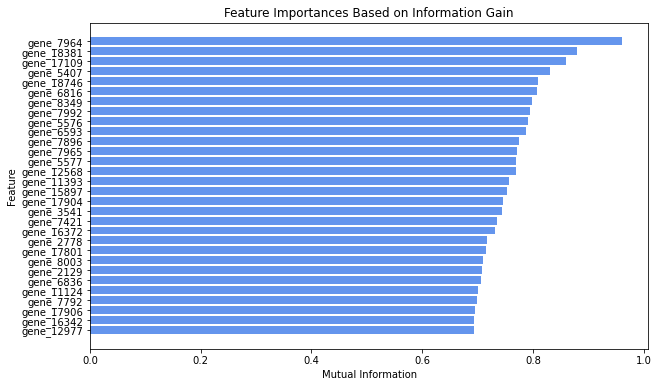

Time:  75.06740608415566


In [71]:
start = timeit.default_timer()

selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_new = selector.fit_transform(X, y['Class'])
mutual_information_scores = selector.scores_
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': mutual_information_scores})
feature_scores_df_infogain = feature_scores_df.sort_values(by='Information Gain', ascending=False)
feature_scores_df_sub = feature_scores_df_infogain[0:num_features] # plot only top

# plot the importances of each feature
plt.figure(figsize=(10, 6))
plt.barh(feature_scores_df_sub['Feature'], feature_scores_df_sub['Information Gain'], color=color)
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Feature Importances Based on Information Gain')
plt.gca().invert_yaxis()  # show the most important features at the top
plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start)  

In [136]:
infogain_features_df = get_selectedfeatures_df(feature_scores_df) 

In [ ]:
# title: characterizing dim red techniques in context of transcriptomic data

In [35]:
infogain_features_df_10 = get_selectedfeatures_df(feature_scores_df, 10) 
infogain_features_df_50 = get_selectedfeatures_df(feature_scores_df, 50) 
infogain_features_df_100 = get_selectedfeatures_df(feature_scores_df, 100) 
infogain_features_df_200 = get_selectedfeatures_df(feature_scores_df, 200) 
infogain_features_df_1K = get_selectedfeatures_df(feature_scores_df, 1000) 
infogain_features_df_5K = get_selectedfeatures_df(feature_scores_df, 5000) 
infogain_features_df_10K = get_selectedfeatures_df(feature_scores_df, 10000) 
infogain_features_df_15K = get_selectedfeatures_df(feature_scores_df, 15000) 

### Fisher's Score

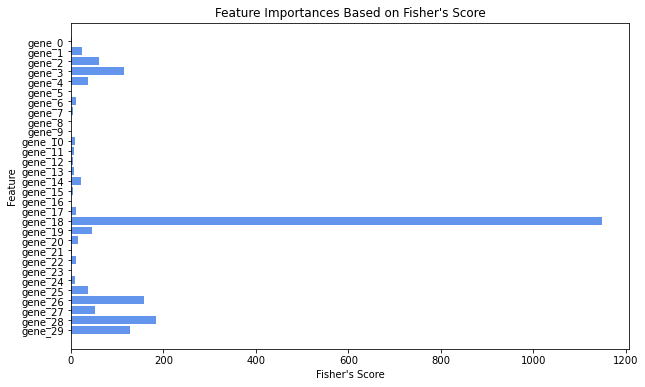

Time:  0.8492509578354657


In [408]:
# Ignore warnings
warnings.filterwarnings("ignore")

start = timeit.default_timer()

selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X, y['Class'])
fishers_scores = selector.scores_
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Fisher_Score': fishers_scores})
feature_scores_df_fish = feature_scores_df.sort_values(by='Fisher_Score', ascending=False)
feature_scores_df_sub = feature_scores_df[0:num_features] # plot only top

# plot the importances of each feature
plt.figure(figsize=(10, 6))
plt.barh(feature_scores_df_sub['Feature'], feature_scores_df_sub['Fisher_Score'], color=color)
plt.xlabel("Fisher's Score")
plt.ylabel('Feature')
plt.title("Feature Importances Based on Fisher's Score")
plt.gca().invert_yaxis()  # show the most important features at the top
plt.show()


stop = timeit.default_timer()
print('Time: ', stop - start)  

In [137]:
fishers_features_df = get_selectedfeatures_df(feature_scores_df)

### Correlation Coefficient

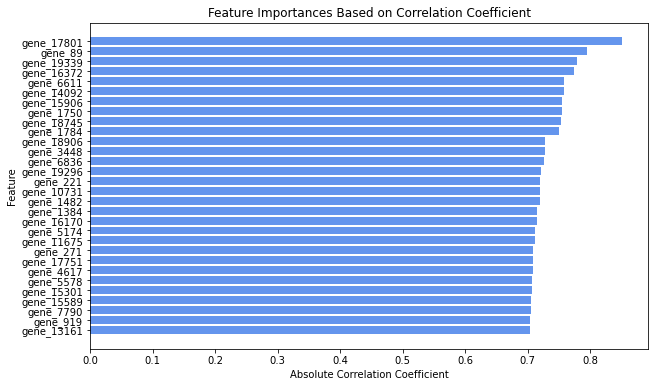

Time:  3.160244165919721


In [73]:
start = timeit.default_timer()

correlation_coefficients = X.apply(lambda col: col.corr(y['Class']))
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Correlation_Coefficient': correlation_coefficients})
feature_scores_df['Correlation_Coefficient'] = np.abs(feature_scores_df['Correlation_Coefficient'])
feature_scores_df_cc = feature_scores_df.sort_values(by='Correlation_Coefficient', ascending=False)
feature_scores_df_sub = feature_scores_df_cc[0:num_features] # plot only top

# plot the importances of each feature
plt.figure(figsize=(10, 6))
plt.barh(feature_scores_df_sub['Feature'], feature_scores_df_sub['Correlation_Coefficient'], color=color)
plt.xlabel('Absolute Correlation Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances Based on Correlation Coefficient')
plt.gca().invert_yaxis()  # show the most important features at the top
plt.show()


stop = timeit.default_timer()
print('Time: ', stop - start)  

In [138]:
corr_features_df = get_selectedfeatures_df(feature_scores_df) 

## Embedded Methods:

### LASSO

In [247]:
# Ignore warnings
warnings.filterwarnings("ignore")

start = timeit.default_timer()

lasso = LassoCV(cv=2)  # can change num folds
lasso.fit(X, y)
coefficients = lasso.coef_
feature_coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# # filter out features with coefficient values equal to zero
selected_features = feature_coefficients_df[feature_coefficients_df['Coefficient'] != 0]

# print the selected features and their coefficients
print("Selected features based on Lasso:")
print(selected_features)

stop = timeit.default_timer()
print('Time: ', stop - start)  

Selected features based on Lasso:
          Feature  Coefficient
26        gene_26     0.001482
61        gene_61    -0.001675
84        gene_84    -0.005736
148      gene_148     0.001302
164      gene_164    -0.000431
...           ...          ...
19500  gene_19500     0.001264
19623  gene_19623     0.004385
19925  gene_19925    -0.000136
20476  gene_20476     0.000436
20504  gene_20504     0.001551

[345 rows x 2 columns]
Time:  67.4757201669272


In [249]:
len(coefficients)

20531

In [113]:
## The following two lines will give the non-zero coeffiecient features
# Lasso_features = selected_features['Feature'].tolist()
# Lasso_features_df = X[X.columns.intersection(Lasso_features)]

## But we can further select if we want
selected_features['Coefficient'] = abs(selected_features['Coefficient'])
Lasso_features_df = get_selectedfeatures_df(selected_features)

### Ridge

In [343]:
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=2)  # You can customize the list of alphas
ridge.fit(X, y)

# Get the coefficients from the trained Ridge model
ridge_coefficients = ridge.coef_

# Create a DataFrame with feature names and their coefficients
feature_coefficients_df_ridge = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge_coefficients[0]})

# # Filter out features with coefficient values equal to zero
selected_features_ridge = feature_coefficients_df[feature_coefficients_df['Coefficient'] != 0]

selected_features_ridge['Coefficient'] = abs(selected_features_ridge['Coefficient'])
Ridge_features_df = get_selectedfeatures_df(selected_features_ridge)

In [344]:
selected_features_ridge_top = selected_features_ridge.head(31)
selected_features_ridge_top

,Feature,Coefficient,Normalized
26,gene_26,0.001482,0.054003
61,gene_61,0.001675,0.061072
84,gene_84,0.005736,0.209193
148,gene_148,0.001302,0.047452
164,gene_164,0.000431,0.015686
203,gene_203,0.006937,0.252998
218,gene_218,0.001362,0.049622
226,gene_226,0.000091,0.003286
238,gene_238,0.005833,0.212736
241,gene_241,0.001170,0.042637


In [378]:
def convert_geneID(genes, df):
    df['Gene_ID'] = df['Feature'].map(genes['gene_id'])
    df['Gene_ID'] = df['Gene_ID'].str.split('|').str[0]
    return df

In [341]:
def plot_polar(genes, df, name, col):
    
    genes_df = convert_geneID(genes, df)
    
    # Plotting on polar axis as dots with larger point size corresponding to importance
    theta = np.linspace(0, 2*np.pi, len(genes_df), endpoint=False)
    values = genes_df[col]

    # Adjust the point size by multiplying with a larger factor
    point_size = values * 10000

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Plotting the dots with larger point size corresponding to importance
    scatter = ax.scatter(theta, values, s=point_size, alpha=0.7, cmap='GnBu', c=values)

    # Adding labels
    ax.set_xticks(theta)
    ax.set_xticklabels(genes_df['Gene_ID'])
    ax.set_yticklabels([])  # Remove radial labels for better clarity

    # Add a colorbar to show the correspondence between size and importance
    cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1)
    cbar.set_label('Importance')

    # Add a title
    plt.title(f'Overlapped Gene Importance ({name})', pad=20)

    plt.show()

Index(['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6',
       'gene_7', 'gene_8', 'gene_9',
       ...
       'gene_20521', 'gene_20522', 'gene_20523', 'gene_20524', 'gene_20525',
       'gene_20526', 'gene_20527', 'gene_20528', 'gene_20529', 'gene_20530'],
      dtype='object', length=20531)
26             ?|729884
61        ABCA11P|79963
84         ABCC12|94160
148            ACADL|33
164            ACCN1|40
203             ACPP|55
218        ACSM1|116285
226         ACSS3|79611
238         ACTL8|81569
241            ACTN2|88
349           ADH1C|126
357         ADIPOQ|9370
375          ADRA1B|147
377          ADRA2A|150
399           AFF3|3899
491         AKAP12|9590
514         AKR1C2|1646
553           ALDOB|229
598       ALS2CL|259173
661       ANGPTL3|27329
1096        ASB5|140458
1105          ASCL2|430
1140        ASXL3|80816
1147      ATAD3C|219293
1199     ATP13A5|344905
1243     ATP6V0A4|50617
1279        ATRIP|84126
1317          AZGP1|563
1345    B4GA

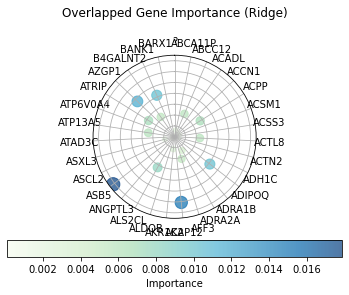

In [356]:
plot_polar(genes, selected_features_ridge_top, "Ridge", 'Coefficient')

# keep order of genes same

### Random Forest

In [422]:
######### using this block for consistence ############
## RF CLASSIFIER ("balanced") ###
start = timeit.default_timer()

rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rf_model.fit(X, y)
importances = rf_model.feature_importances_

feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  3.971530499868095


In [139]:
RF_features_df = get_selectedfeatures_df(feature_importances_df)

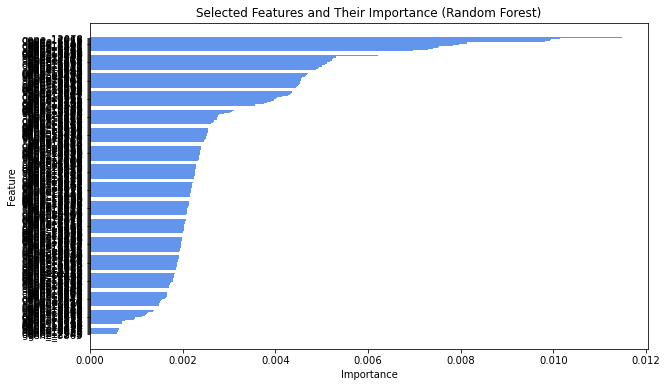

In [272]:
## plot the selected features and their importances
feature_importances_df.set_index('Feature', inplace=True)
selected_features = feature_importances_df.loc[RF_features_df.columns]
selected_features.reset_index(inplace=True)
selected_features.columns = ['Feature', 'Importance', 'Normalized']
selected_features = selected_features.sort_values(by=['Importance'], ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Feature'], selected_features['Importance'], color=color)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Selected Features and Their Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.show()

In [273]:
selected_features

,Feature,Importance,Normalized
190,gene_12078,0.011471,1.000000
187,gene_12013,0.010136,0.883603
100,gene_6355,0.009958,0.868106
53,gene_3523,0.009919,0.864708
35,gene_1923,0.009821,0.856131
...,...,...,...
71,gene_4672,0.000621,0.054174
309,gene_19606,0.000608,0.053007
129,gene_7932,0.000597,0.052008
194,gene_12245,0.000588,0.051252


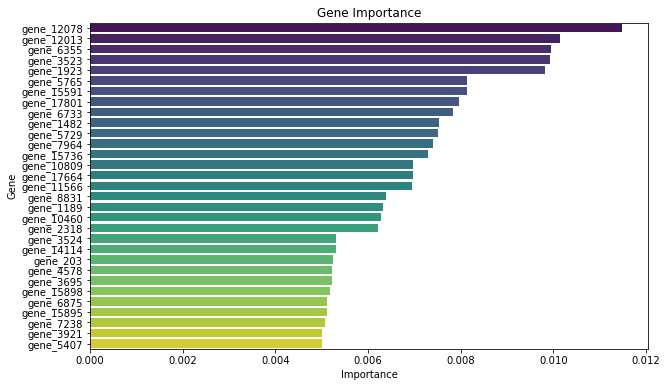

In [276]:
top_genes_df = selected_features.head(31)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_genes_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Gene')
plt.title('Gene Importance')
plt.show()

In [296]:
genes.index = 'gene_' + genes.index.astype(str)

top_genes_df['Gene_ID'] = top_genes_df['Feature'].map(genes['gene_id'])

In [300]:
top_genes_df['Gene_ID'] = top_genes_df['Gene_ID'].str.split('|').str[0]
top_genes_df

,Feature,Importance,Normalized,Gene_ID
190,gene_12078,0.011471,1.000000,NR1H4
187,gene_12013,0.010136,0.883603,NOX1
100,gene_6355,0.009958,0.868106,FERD3L
53,gene_3523,0.009919,0.864708,CDX1
35,gene_1923,0.009821,0.856131,C15orf21
90,gene_5765,0.008143,0.709843,EVX1
233,gene_15591,0.008129,0.708647,SCGB3A1
281,gene_17801,0.007966,0.694434,TCF15
107,gene_6733,0.007831,0.682665,FXYD2
25,gene_1482,0.007539,0.657173,BEND4


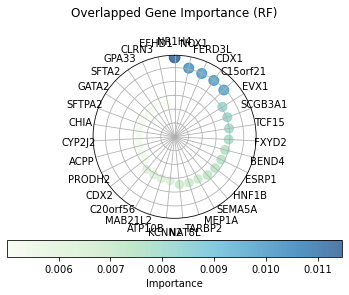

In [321]:
plot_polar(top_genes_df, 'RF')

# Testing

In [25]:
X_train_og, X_test_og, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)# stratify: proportion

In [444]:
def test_MLP(selected_features_df):
    start = timeit.default_timer()
        
    X_train = X_train_og[selected_features_df.columns]
    X_test = X_test_og[selected_features_df.columns]
    
    print(f'number of selected features: {X_train.shape[1]}')
    num_layer = int(np.sqrt(X_train.shape[1]*len(y['Class'].unique())))

    mlp_classifier = MLPClassifier(hidden_layer_sizes=(num_layer, ), 
                                   learning_rate='adaptive',
                                   max_iter=10000, early_stopping=True)

    mlp_classifier.fit(X_train, y_train)
    y_pred = mlp_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test), 
                        average='macro', multi_class='ovr')

    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-score: {f1:.2%}")
    print(f"AUC: {auc:.2%}")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

    # Calculate sensitivity and specificity
    sensitivity = recall_score(y_test, y_pred, average='macro')
    specificity = (conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]))  # Specificity for binary classification

    print(f"Sensitivity: {sensitivity:.2%}")
    print(f"Specificity: {specificity:.2%}")

    # Bar plot of sensitivity and specificity
    sns.barplot(x=['Sensitivity', 'Specificity'], y=[sensitivity, specificity])
    plt.title('Sensitivity and Specificity')
    plt.show()
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    
    return sensitivity, specificity

In [49]:
def test_range(features_df, num_genes):
    
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    aucs = []
    
    times = []
    
    for i in num_genes:
    
        features = features_df.sort_values(by=features_df.columns[1], ascending=False).iloc[0:i]['Feature']
        selected_features_df = X[X.columns.intersection(features)]
        
        start = timeit.default_timer()

        X_train = X_train_og[selected_features_df.columns]
        X_test = X_test_og[selected_features_df.columns]

        print(f'number of selected features: {X_train.shape[1]}')
        num_layer = int(np.sqrt(X_train.shape[1]*len(y['Class'].unique())))

        mlp_classifier = MLPClassifier(hidden_layer_sizes=(num_layer, ), 
                                       learning_rate='adaptive',
                                       max_iter=10000, early_stopping=True)

        mlp_classifier.fit(X_train, y_train)
        y_pred = mlp_classifier.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='micro')
        recall = recall_score(y_test, y_pred, average='micro')
        f1 = f1_score(y_test, y_pred, average='micro')
        auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test), 
                            average='macro', multi_class='ovr')

        stop = timeit.default_timer()
 
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        aucs.append(auc)
        
        times.append(stop-start)  
        
    return accuracies, precisions, recalls, f1s, aucs, times

# 1, 4, 5, 10, 15, 20, 25, 35, 50, 100, 250, 500, 1K, 5K, 10K, 15K, ALL (20K) GENES

In [107]:
num_genes = [1, 4, 5, 10, 15, 20, 25, 35, 50, 100, 250, 500, 1000, 8000, 15000, 20531]

## Baseline (all features):

number of selected features: 20531
Accuracy: 96.89%
Precision: 96.89%
Recall: 96.89%
F1-score: 96.89%
AUC: 100.00%
[[55  0  0  5  0]
 [ 0 16  0  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  0 27]]
Sensitivity: 98.33%
Specificity: 100.00%


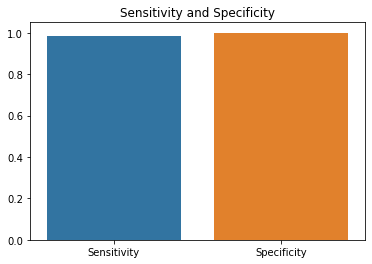

Time:  45.51546812499873


In [445]:
all_sens, all_spec = test_MLP(X)

## Filter:

### Information Gain

number of selected features: 16889
Accuracy: 99.38%
Precision: 99.38%
Recall: 99.38%
F1-score: 99.38%
AUC: 100.00%
[[59  1  0  0  0]
 [ 0 16  0  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  0 27]]
Sensitivity: 99.67%
Specificity: 98.33%


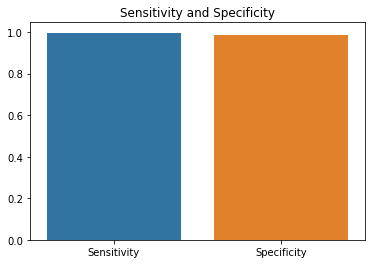

Time:  33.00927562499419


In [446]:
IG_sens, IG_spec = test_MLP(infogain_features_df)

In [119]:
ig_accuracies, ig_precisions, ig_recalls, ig_f1s, ig_aucs, ig_times = test_range(feature_scores_df_infogain, num_genes)


number of selected features: 1
number of selected features: 4
number of selected features: 5
number of selected features: 10
number of selected features: 15
number of selected features: 20
number of selected features: 25
number of selected features: 35
number of selected features: 50
number of selected features: 100
number of selected features: 250
number of selected features: 500
number of selected features: 1000
number of selected features: 8000
number of selected features: 15000
number of selected features: 20531


### Fisher's Score

number of selected features: 16889
Accuracy: 98.76%
Precision: 98.76%
Recall: 98.76%
F1-score: 98.76%
AUC: 100.00%
[[60  0  0  0  0]
 [ 0 14  0  2  0]
 [ 0  0 30  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  0 27]]
Sensitivity: 97.50%
Specificity: 100.00%


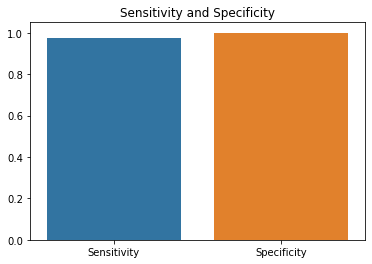

Time:  35.0458827088587


In [447]:
fish_sens, fish_spec = test_MLP(fishers_features_df)

In [120]:
fisher_accuracies, fisher_precisions, fisher_recalls, fisher_f1s, fisher_aucs, fisher_times = test_range(feature_scores_df, num_genes)

number of selected features: 1
number of selected features: 4
number of selected features: 5
number of selected features: 10
number of selected features: 15
number of selected features: 20
number of selected features: 25
number of selected features: 35
number of selected features: 50
number of selected features: 100
number of selected features: 250
number of selected features: 500
number of selected features: 1000
number of selected features: 8000
number of selected features: 15000
number of selected features: 20531


### Correlation Coefficient

number of selected features: 16889
Accuracy: 98.14%
Precision: 98.14%
Recall: 98.14%
F1-score: 98.14%
AUC: 100.00%
[[60  0  0  0  0]
 [ 0 14  2  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 28  0]
 [ 1  0  0  0 26]]
Sensitivity: 96.76%
Specificity: 100.00%


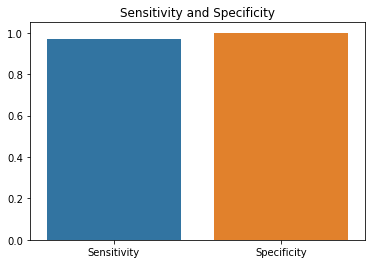

Time:  20.84810454212129


In [448]:
cc_sens, cc_spec = test_MLP(corr_features_df)

In [121]:
cc_accuracies, cc_precisions, cc_recalls, cc_f1s, cc_aucs, cc_times = test_range(feature_scores_df_cc, num_genes)


number of selected features: 1
number of selected features: 4
number of selected features: 5
number of selected features: 10
number of selected features: 15
number of selected features: 20
number of selected features: 25
number of selected features: 35
number of selected features: 50
number of selected features: 100
number of selected features: 250
number of selected features: 500
number of selected features: 1000
number of selected features: 8000
number of selected features: 15000
number of selected features: 20531


## Embedded:

### Lasso

number of selected features: 221
Accuracy: 97.52%
Precision: 97.52%
Recall: 97.52%
F1-score: 97.52%
AUC: 99.93%
[[59  0  0  1  0]
 [ 0 15  0  1  0]
 [ 0  0 30  0  0]
 [ 1  0  0 27  0]
 [ 0  0  0  1 26]]
Sensitivity: 96.96%
Specificity: 100.00%


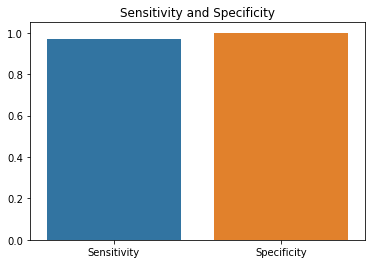

Time:  0.23899404099211097


In [449]:
lasso_sens, lasso_spec = test_MLP(Lasso_features_df)

In [122]:
lasso_accuracies, lasso_precisions, lasso_recalls, lasso_f1s, lasso_aucs, lasso_times = test_range(selected_features, num_genes)


number of selected features: 1
number of selected features: 4
number of selected features: 5
number of selected features: 10
number of selected features: 15
number of selected features: 20
number of selected features: 25
number of selected features: 35
number of selected features: 50
number of selected features: 100
number of selected features: 250
number of selected features: 345
number of selected features: 345
number of selected features: 345
number of selected features: 345
number of selected features: 345


In [263]:
lasso_accuracies

[0.14285714285714285,
 0.2546583850931677,
 0.031055900621118012,
 0.8819875776397516,
 0.9813664596273292,
 0.16149068322981366,
 0.968944099378882,
 0.9627329192546584,
 0.9503105590062112,
 0.968944099378882,
 0.9751552795031055,
 0.9937888198757764,
 0.968944099378882,
 0.9875776397515528,
 0.9751552795031055,
 0.9937888198757764]

### Ridge

number of selected features: 221
Accuracy: 99.38%
Precision: 99.38%
Recall: 99.38%
F1-score: 99.38%
AUC: 100.00%
[[59  0  0  1  0]
 [ 0 16  0  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  0 27]]
Sensitivity: 99.67%
Specificity: 100.00%


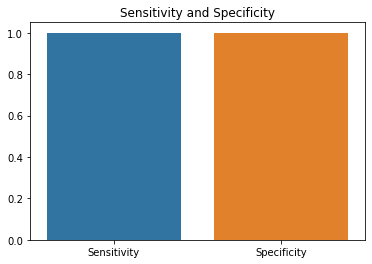

Time:  0.21093762503005564


In [450]:
ridge_sens, ridge_spec = test_MLP(Ridge_features_df)

In [259]:
ridge_accuracies, ridge_precisions, ridge_recalls, ridge_f1s, ridge_aucs, ridge_times = test_range(selected_features_ridge, num_genes)


number of selected features: 1
number of selected features: 4
number of selected features: 5
number of selected features: 10
number of selected features: 15
number of selected features: 20
number of selected features: 25
number of selected features: 35
number of selected features: 50
number of selected features: 100
number of selected features: 250
number of selected features: 345
number of selected features: 345
number of selected features: 345
number of selected features: 345
number of selected features: 345


In [262]:
ridge_accuracies

[0.09937888198757763,
 0.18012422360248448,
 0.11180124223602485,
 0.09937888198757763,
 0.18012422360248448,
 0.9316770186335404,
 0.2795031055900621,
 0.9937888198757764,
 0.9565217391304348,
 0.9565217391304348,
 1.0,
 0.9937888198757764,
 0.9875776397515528,
 1.0,
 0.9751552795031055,
 0.9813664596273292]

### Random Forest

number of selected features: 313
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-score: 100.00%
AUC: 100.00%
[[60  0  0  0  0]
 [ 0 16  0  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  0 27]]
Sensitivity: 100.00%
Specificity: 100.00%


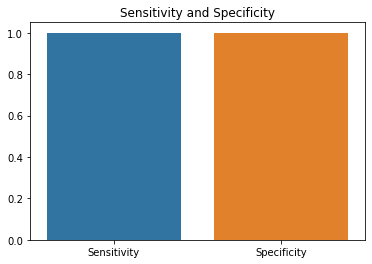

Time:  0.3111664999742061


In [451]:
RF_sens, RF_spec = test_MLP(RF_features_df)

In [123]:
RF_accuracies, RF_precisions, RF_recalls, RF_f1s, RF_aucs, RF_times = test_range(feature_importances_df, num_genes)

number of selected features: 1
number of selected features: 4
number of selected features: 5
number of selected features: 10
number of selected features: 15
number of selected features: 20
number of selected features: 25
number of selected features: 35
number of selected features: 50
number of selected features: 100
number of selected features: 250
number of selected features: 500
number of selected features: 1000
number of selected features: 8000
number of selected features: 15000
number of selected features: 20531


In [61]:
RF_accuracies

[0.2422360248447205,
 0.9503105590062112,
 0.9565217391304348,
 0.9813664596273292,
 0.968944099378882,
 1.0,
 0.9813664596273292,
 0.8819875776397516,
 1.0]

# Comparison Plots

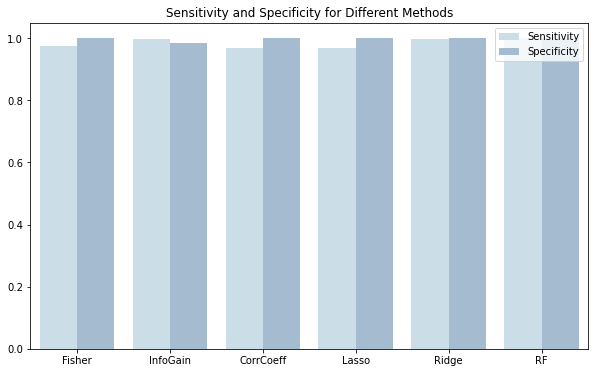

In [461]:
# plot all sensitivity and specificity
methods = ['Fisher', 'InfoGain', 'CorrCoeff', 'Lasso', 'Ridge', 'RF']
sensitivity_values = [fish_sens, IG_sens, cc_sens, lasso_sens, ridge_sens, RF_sens]
specificity_values = [fish_spec, IG_spec, cc_spec, lasso_spec, ridge_spec, RF_spec]

colors = sns.color_palette("ch:s=.25,rot=-.25")

# Plotting sensitivity and specificity for each method
plt.figure(figsize=(10, 6))
sns.barplot(x=methods * 2, y=sensitivity_values + specificity_values, hue=['Sensitivity'] * len(methods) + ['Specificity'] * len(methods), palette=colors)
plt.title('Sensitivity and Specificity for Different Methods')
plt.show()

In [158]:
zoom = 11

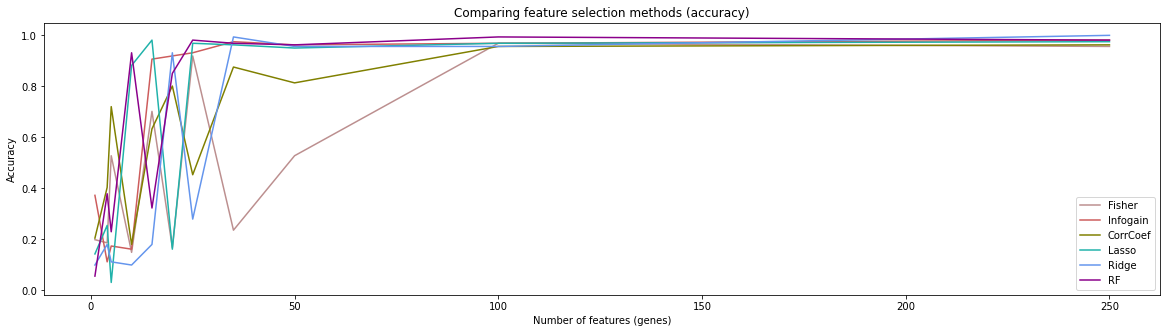

In [269]:
plt.plot(num_genes[0:zoom], fisher_accuracies[0:zoom], c = 'rosybrown')
plt.plot(num_genes[0:zoom], ig_accuracies[0:zoom], c = 'indianred')
plt.plot(num_genes[0:zoom], cc_accuracies[0:zoom], c = 'olive')
plt.plot(num_genes[0:zoom], lasso_accuracies[0:zoom], c = 'lightseagreen')
plt.plot(num_genes[0:zoom], ridge_accuracies[0:zoom], c = 'cornflowerblue')
plt.plot(num_genes[0:zoom], RF_accuracies[0:zoom], c = 'darkmagenta')

plt.xlabel("Number of features (genes)")
plt.ylabel("Accuracy")
plt.title("Comparing feature selection methods (accuracy)")

plt.gcf().set_size_inches(20, 5)

plt.legend(['Fisher', 'Infogain', 'CorrCoef', 'Lasso', 'Ridge', 'RF'])

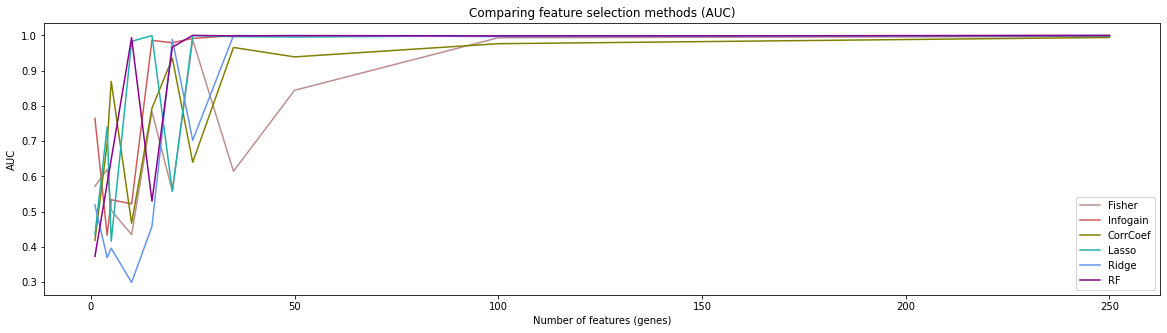

In [270]:
plt.plot(num_genes[0:zoom], fisher_aucs[0:zoom], c = 'rosybrown')
plt.plot(num_genes[0:zoom], ig_aucs[0:zoom], c = 'indianred')
plt.plot(num_genes[0:zoom], cc_aucs[0:zoom], c = 'olive')
plt.plot(num_genes[0:zoom], lasso_aucs[0:zoom], c = 'lightseagreen')
plt.plot(num_genes[0:zoom], ridge_aucs[0:zoom], c = 'cornflowerblue')
plt.plot(num_genes[0:zoom], RF_aucs[0:zoom], c = 'darkmagenta')

plt.xlabel("Number of features (genes)")
plt.ylabel("AUC")
plt.title("Comparing feature selection methods (AUC)")

plt.gcf().set_size_inches(20, 5)

plt.legend(['Fisher', 'Infogain', 'CorrCoef', 'Lasso', 'Ridge', 'RF'])

In [ ]:
# determine 100 genes until convergence for each method, check overlap of those


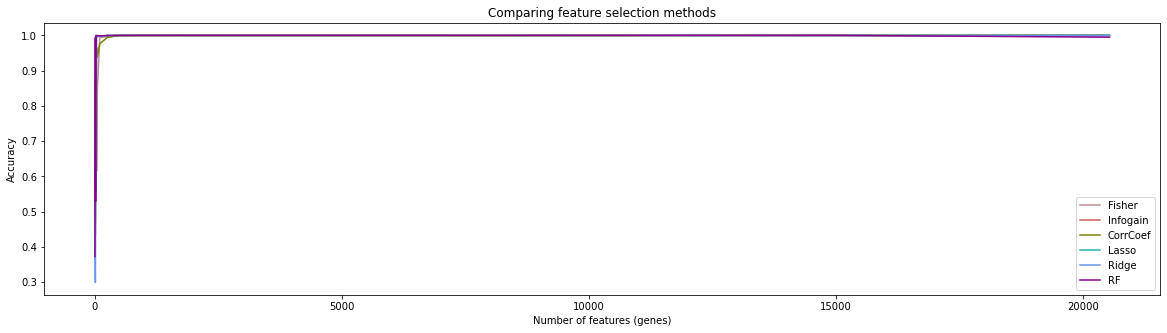

In [472]:
plt.plot(num_genes, fisher_aucs, c = 'rosybrown')
plt.plot(num_genes, ig_aucs, c = 'indianred')
plt.plot(num_genes, cc_aucs, c = 'olive')
plt.plot(num_genes, lasso_aucs, c = 'lightseagreen')
plt.plot(num_genes, ridge_aucs, c = 'cornflowerblue')
plt.plot(num_genes, RF_aucs, c = 'darkmagenta')

plt.xlabel("Number of features (genes)")
plt.ylabel("Accuracy")
plt.title("Comparing feature selection methods")

plt.gcf().set_size_inches(20, 5)

plt.legend(['Fisher', 'Infogain', 'CorrCoef', 'Lasso', 'Ridge', 'RF'])

# Analyze gene similarities/diff

In [ ]:
# check number of patients correctly and incorreclty classified for cancer type per selection method -- any patterns?
# if most misclassified cases are from a particular type of cancer?

In [497]:
# get all colnames (only take number)
# check overlap btwn significant genes

# Get all column names
infogain_columns = set(infogain_features_df.columns)
fishers_columns = set(fishers_features_df.columns)
corr_columns = set(corr_features_df.columns)
lasso_columns = set(Lasso_features_df.columns)
rf_columns = set(RF_features_df.columns)

# Check overlap between significant genes
overlap_genes = infogain_columns & fishers_columns & corr_columns & lasso_columns & rf_columns

overlap_gene_nums = {name.replace('gene_', '') for name in overlap_genes}
overlap_gene_nums = {int(name) for name in overlap_gene_nums}

len(overlap_gene_nums)

31

number of selected features: 31
Accuracy: 91.93%
Precision: 91.93%
Recall: 91.93%
F1-score: 91.93%
AUC: 98.61%
[[55  0  4  0  1]
 [ 0 12  2  0  2]
 [ 0  0 28  0  2]
 [ 0  0  0 28  0]
 [ 0  0  2  0 25]]
Sensitivity: 90.52%
Specificity: 100.00%


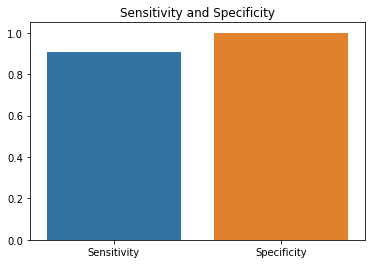

Time:  0.22929574991576374


(0.9051851851851851, 1.0)

In [498]:
# test classification performance with just 31 genes
overlap_df = infogain_features_df[overlap_genes]
test_MLP(overlap_df)

In [499]:
new_cols = overlap_df.columns.map(genes['gene_id'])
new_cols = new_cols.str.split('|').str[0]
new_cols

Index(['C20orf56', 'KLKB1', 'NKX3-1', 'NKX2-1', 'KLK15', 'HAND2', 'MUC13',
       'SLC34A1', 'SFTPA2', 'FABP12', 'SFTPA1', 'FLJ45983', 'SFTA3', 'TCF15',
       'ASB5', 'PHGR1', 'ACPP', 'PAGE4', 'SPOCK2', 'HNF1B', 'PCCB', 'SFTA2',
       'SFTPC', 'LMX1B', 'PRLHR', 'ADIPOQ', 'SOX18', 'NPY6R', 'EMX2', 'CDX1',
       'NAP1L2'],
      dtype='object')

In [500]:
overlap_df.columns = new_cols
overlap_df

,C20orf56,KLKB1,NKX3-1,NKX2-1,KLK15,HAND2,MUC13,SLC34A1,SFTPA2,FABP12,...,SFTA2,SFTPC,LMX1B,PRLHR,ADIPOQ,SOX18,NPY6R,EMX2,CDX1,NAP1L2
sample_0,2.476226,6.720744,13.764913,0.000000,17.173570,5.663951,2.602077,5.248778,1.334282,0.000000,...,0.000000,7.020347,5.748037,5.663951,0.000000,4.747656,4.692126,5.939029,1.822037,8.072995
sample_1,2.592278,0.000000,2.328951,11.328675,0.000000,0.000000,4.293724,13.043398,13.609213,0.000000,...,10.068832,10.100859,1.465034,3.841047,0.000000,0.587845,0.000000,0.587845,1.327170,2.328951
sample_2,0.000000,6.875829,14.747134,0.000000,14.818422,1.306846,11.369221,0.000000,1.074163,2.785739,...,0.000000,3.403377,2.533663,5.726766,0.452595,7.082149,14.766151,0.000000,2.438799,7.995829
sample_3,1.931418,5.524474,14.679689,0.000000,17.371079,0.000000,5.524474,5.191041,0.434882,1.464093,...,0.000000,5.105175,2.566840,6.343552,0.000000,1.464093,8.653719,0.768587,1.039419,9.531598
sample_4,0.000000,2.967630,7.919239,0.000000,1.580097,5.024776,2.544139,10.309636,1.095654,0.000000,...,0.000000,3.163434,10.828644,14.189315,3.208502,0.000000,0.000000,5.168542,2.678342,5.564878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_796,0.000000,4.345403,8.831041,0.000000,1.955573,5.465315,0.000000,5.543722,0.000000,0.000000,...,0.000000,3.781181,10.990508,13.284359,8.202726,0.000000,0.496922,6.335924,2.354001,4.896592
sample_797,7.714871,0.000000,3.334983,13.280877,0.618051,0.000000,11.221043,13.003558,18.640513,0.000000,...,12.005982,12.096587,2.400019,4.339943,0.618051,4.484808,0.000000,0.000000,2.073340,2.539233
sample_798,7.563631,2.003926,6.243574,6.920234,3.648673,6.362728,11.752590,2.911423,1.325099,11.518225,...,4.677458,2.173991,6.993878,7.763438,4.619736,1.325099,3.092089,8.139649,9.643669,7.204874
sample_799,3.079224,6.568180,14.053417,6.452648,16.418269,3.239566,7.833042,5.823709,2.577175,0.581881,...,3.239566,5.691272,5.649049,6.897616,0.581881,4.161098,16.649719,2.991826,0.000000,7.365745


In [176]:
len(lasso_columns) # least num features

221

In [ ]:
# check if 31 overlap are in top 30 of individual selection algos

In [503]:
overlap_gene_ids

17026        SOX18|54345
6530     FLJ45983|399717
11910        NKX3-1|4824
17801         TCF15|6939
14092         PRLHR|2834
2318     C20orf56|140828
17168        SPOCK2|9806
11540        NAP1L2|4674
15895       SFTA2|389376
15896       SFTA3|253970
15897      SFTPA1|653509
15898      SFTPA2|729238
16283       SLC34A1|6569
15900         SFTPC|6440
7964          HNF1B|6928
12069         NPY6R|4888
13355       PHGR1|644844
9652          LMX1B|4010
3523           CDX1|1044
5829       FABP12|646486
7623          HAND2|9464
5576           EMX2|2018
1096         ASB5|140458
203              ACPP|55
13004          PCCB|5096
12881         PAGE4|9506
11346        MUC13|56667
9175         KLK15|55554
9184          KLKB1|3818
357          ADIPOQ|9370
11903        NKX2-1|7080
Name: gene_id, dtype: object

In [506]:
# map overlap genes to id

# overlap_gene_ids = genes.loc[overlap_gene_nums, "gene_id"]
overlap_genes = [entry.split('|')[0] for entry in overlap_gene_ids]
overlap_genes

['SOX18',
 'FLJ45983',
 'NKX3-1',
 'TCF15',
 'PRLHR',
 'C20orf56',
 'SPOCK2',
 'NAP1L2',
 'SFTA2',
 'SFTA3',
 'SFTPA1',
 'SFTPA2',
 'SLC34A1',
 'SFTPC',
 'HNF1B',
 'NPY6R',
 'PHGR1',
 'LMX1B',
 'CDX1',
 'FABP12',
 'HAND2',
 'EMX2',
 'ASB5',
 'ACPP',
 'PCCB',
 'PAGE4',
 'MUC13',
 'KLK15',
 'KLKB1',
 'ADIPOQ',
 'NKX2-1']

In [207]:
overlap_gene_ids

17026        SOX18|54345
6530     FLJ45983|399717
11910        NKX3-1|4824
17801         TCF15|6939
14092         PRLHR|2834
2318     C20orf56|140828
17168        SPOCK2|9806
11540        NAP1L2|4674
15895       SFTA2|389376
15896       SFTA3|253970
15897      SFTPA1|653509
15898      SFTPA2|729238
16283       SLC34A1|6569
15900         SFTPC|6440
7964          HNF1B|6928
12069         NPY6R|4888
13355       PHGR1|644844
9652          LMX1B|4010
3523           CDX1|1044
5829       FABP12|646486
7623          HAND2|9464
5576           EMX2|2018
1096         ASB5|140458
203              ACPP|55
13004          PCCB|5096
12881         PAGE4|9506
11346        MUC13|56667
9175         KLK15|55554
9184          KLKB1|3818
357          ADIPOQ|9370
11903        NKX2-1|7080
Name: gene_id, dtype: object

In [188]:
# CANCERS
# BRCA: Breast Invasive Carcinoma
# KIRC: Kidney Renal Clear Cell Carcinoma
# COAD: Colon Adenocarcinoma
# LUAD: Lung Adenocarcinoma
# PRAD: Prostate Adenocarcinoma

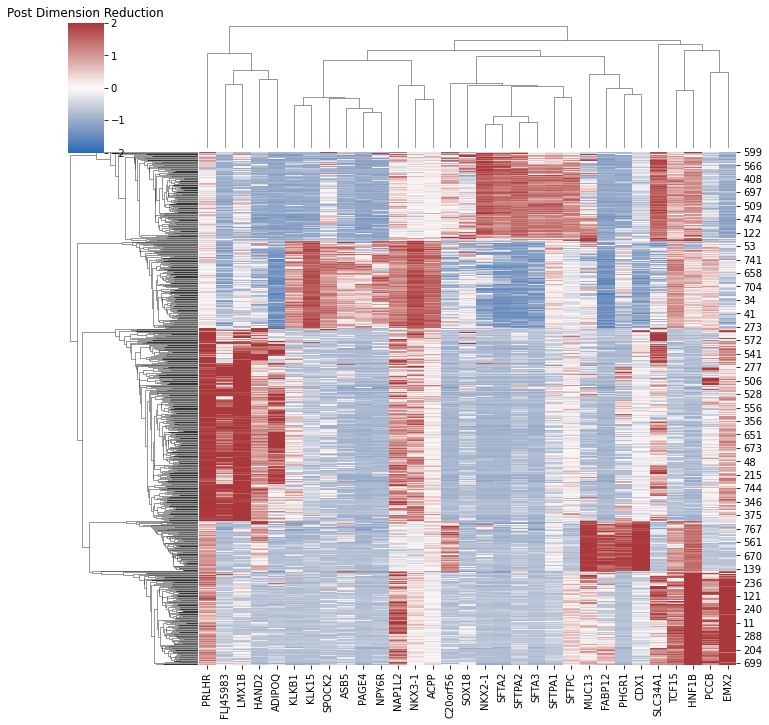

In [441]:
order = y['Class'].argsort()
overlap_normalized = overlap_df.iloc[order]

# Normalize each column for better visualization
scaler = MinMaxScaler()
overlap_normalized = pd.DataFrame(scaler.fit_transform(overlap_df.values), columns=overlap_df.columns)

# Apply z-score normalization and set the color scale from -2 to 2
sns.clustermap(overlap_normalized, cmap="vlag", z_score=0, vmin=-2, vmax=2)

plt.title("Post Dimension Reduction")
plt.show()

In [548]:
order_genes = ['PRLHR', 'FLJ45983', 'LMX1B', 'HAND2', 'ADIPOQ', 'KLKB1', 'SPOCK2', 'ASB5', 'PAGE4', 'NPY6R', 'NAP1L2', 'NKX3-1', 'ACPP', 'C20orf56', 'SOX18', 'NKX2-1', 'SFTA2', 'SFTPA2', 'SFTA3', 'SFTPA1', 'SFTPC', 'MUC13', 'FABP12', 'PHGR1', 'CDX1', 'SLC34A1', 'TCF15', 'HNF1B', 'PCCB', 'EMX2']


,cluster,TCF15,HNF1B,SPOCK2,ASB5,PAGE4,NPY6R,KLKB1,KLK15,PCCB,...,SFTPA2,SFTA3,SFTPA1,SFTPC,EMX2,PRLHR,FLJ45983,LMX1B,HAND2,ADIPOQ
0,4,0.739927,0.396663,0.678861,0.470716,0.700631,0.261736,0.708678,0.940912,0.536978,...,0.065457,0.032033,0.492455,0.462610,0.493754,0.357113,0.400584,0.437311,0.564733,0.000000
1,0,0.451757,0.294039,0.281252,0.032470,0.000000,0.000000,0.000000,0.000000,0.248570,...,0.667637,0.732376,0.718588,0.665602,0.048872,0.242179,0.049319,0.111460,0.000000,0.000000
2,3,0.090283,0.081177,0.481138,0.045405,0.000000,0.823686,0.725031,0.811878,0.031311,...,0.052696,0.058135,0.419420,0.224267,0.000000,0.361074,0.000000,0.192761,0.130301,0.033136
3,1,0.486308,0.200269,0.533675,0.614790,0.120366,0.482722,0.582536,0.951733,0.420905,...,0.021334,0.228198,0.603866,0.336408,0.063898,0.399962,0.106329,0.195285,0.000000,0.000000
4,3,0.120691,0.000000,0.263270,0.036214,0.000000,0.000000,0.312926,0.086571,0.189629,...,0.053750,0.019537,0.236269,0.208456,0.429698,0.894639,0.595158,0.823844,0.501003,0.234905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.027719,0.458207,0.107143,0.367318,...,0.000000,0.000000,0.145845,0.249163,0.526750,0.837581,0.832205,0.836158,0.544927,0.600548
797,3,0.428152,0.717036,0.052203,0.000000,0.000000,0.000000,0.000000,0.033862,0.000000,...,0.914461,0.870512,0.877952,0.797111,0.000000,0.273634,0.000000,0.182594,0.000000,0.045250
798,5,0.728309,0.536010,0.691143,0.058857,0.299963,0.172483,0.211307,0.199905,0.332930,...,0.065006,0.031753,0.068009,0.143256,0.676707,0.489486,0.151948,0.532094,0.634405,0.338226
799,0,0.724511,0.629390,0.717820,0.629628,0.557283,0.928755,0.692591,0.899531,0.572712,...,0.126430,0.000000,0.349562,0.375029,0.248732,0.434896,0.234861,0.429780,0.323006,0.042601


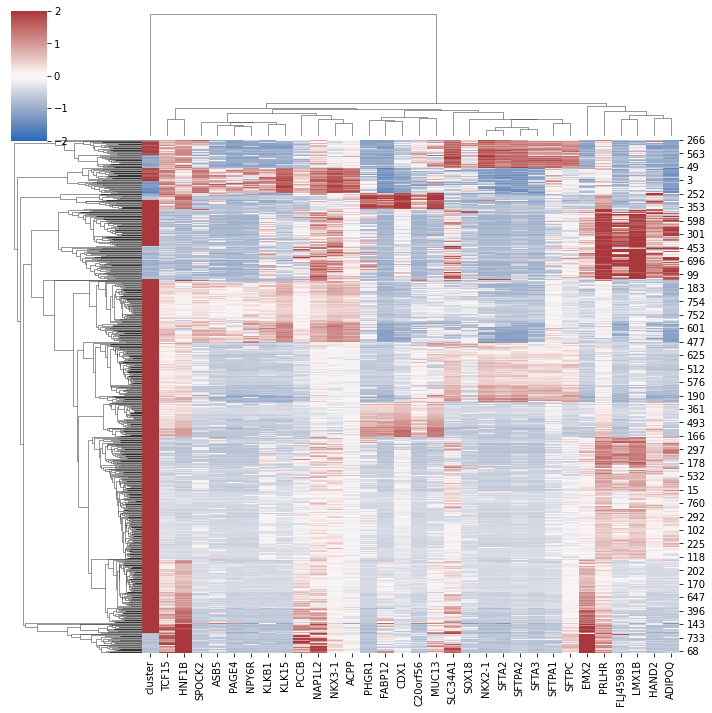

In [543]:
# Create the clustermap
clusmap = sns.clustermap(overlap_normalized, cmap="vlag", z_score=0, vmin=-2, vmax=2)

In [507]:
overlap_genes

['SOX18',
 'FLJ45983',
 'NKX3-1',
 'TCF15',
 'PRLHR',
 'C20orf56',
 'SPOCK2',
 'NAP1L2',
 'SFTA2',
 'SFTA3',
 'SFTPA1',
 'SFTPA2',
 'SLC34A1',
 'SFTPC',
 'HNF1B',
 'NPY6R',
 'PHGR1',
 'LMX1B',
 'CDX1',
 'FABP12',
 'HAND2',
 'EMX2',
 'ASB5',
 'ACPP',
 'PCCB',
 'PAGE4',
 'MUC13',
 'KLK15',
 'KLKB1',
 'ADIPOQ',
 'NKX2-1']

In [488]:
# get bar plot for each cluster
new_cols = X.columns.map(genes['gene_id'])
new_cols = new_cols.str.split('|').str[0]
X.columns = new_cols

In [509]:
X_genes = X[overlap_genes]
X_genes

,SOX18,FLJ45983,NKX3-1,TCF15,PRLHR,C20orf56,SPOCK2,NAP1L2,SFTA2,SFTA3,...,EMX2,ASB5,ACPP,PCCB,PAGE4,MUC13,KLK15,KLKB1,ADIPOQ,NKX2-1
sample_0,4.747656,4.774634,13.764913,8.803453,5.663951,2.476226,8.037228,8.072995,0.000000,0.591871,...,5.939029,4.692126,15.673080,7.761870,8.522283,2.602077,17.173570,6.720744,0.000000,0.000000
sample_1,0.587845,0.587845,2.328951,5.374883,3.841047,2.592278,3.329827,2.328951,10.068832,13.532125,...,0.587845,0.323658,9.184930,3.593007,0.000000,4.293724,0.000000,0.000000,0.000000,11.328675
sample_2,7.082149,0.000000,14.747134,1.074163,5.726766,0.000000,5.696331,7.995829,0.000000,1.074163,...,0.000000,0.452595,13.804736,0.452595,0.000000,11.369221,14.818422,6.875829,0.452595,0.000000
sample_3,1.464093,1.267356,14.679689,5.785961,6.343552,1.931418,6.318335,9.531598,0.000000,4.216416,...,0.768587,6.128269,17.472493,6.084066,1.464093,5.524474,17.371079,5.524474,0.000000,0.000000
sample_4,0.000000,7.093793,7.919239,1.435949,14.189315,0.000000,3.116930,5.564878,0.000000,0.360982,...,5.168542,0.360982,4.056150,2.741035,0.000000,2.544139,1.580097,2.967630,3.208502,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_796,0.000000,9.919204,8.831041,0.000000,13.284359,0.000000,0.000000,4.896592,0.000000,0.000000,...,6.335924,0.000000,4.374302,5.309475,0.000000,0.000000,1.955573,4.345403,8.202726,0.000000
sample_797,4.484808,0.000000,3.334983,5.094029,4.339943,7.714871,0.618051,2.539233,12.005982,16.084458,...,0.000000,0.000000,6.922685,0.000000,0.000000,11.221043,0.618051,0.000000,0.618051,13.280877
sample_798,1.325099,1.811101,6.243574,8.665222,7.763438,7.563631,8.182643,7.204874,4.677458,0.586693,...,8.139649,0.586693,5.648992,4.812406,3.648673,11.752590,3.648673,2.003926,4.619736,6.920234
sample_799,4.161098,2.799357,14.053417,8.620033,6.897616,3.079224,8.498474,7.365745,3.239566,0.000000,...,2.991826,6.276175,15.646449,8.278394,6.778642,7.833042,16.418269,6.568180,0.581881,6.452648


In [526]:
merged_df = pd.merge(X_genes, y, left_index=True, right_index=True)

# Create a dictionary to store DataFrames for each class
class_dfs = {}

# Iterate through unique classes and create separate DataFrames
for class_value in y['Class'].unique():
    class_df = merged_df[merged_df['Class'] == class_value].copy()
    # Drop the 'class' column
    class_df = class_df.drop(columns=['Class'])
    class_dfs[class_value] = class_df
    
# ex. class_dfs[0] corresponds to class 0 samples

In [554]:
## put samples with the sample label together
order = y['Class'].argsort()
X_normalized = X.iloc[order]
## Normalize each column for better visualization
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.values)

[[0.         0.32342445 0.53855624 ... 0.21354593 0.44222065 0.        ]
 [0.         0.09503429 0.26196506 ... 0.30983781 0.14136949 0.        ]
 [0.         0.56304952 0.71364896 ... 0.44979441 0.1026255  0.        ]
 ...
 [0.         0.52101397 0.61144582 ... 0.32375161 0.38480361 0.11166309]
 [0.         0.41531576 0.45979768 ... 0.51245842 0.48292902 0.        ]
 [0.         0.37281222 0.62768079 ... 0.40015071 0.37286023 0.        ]]


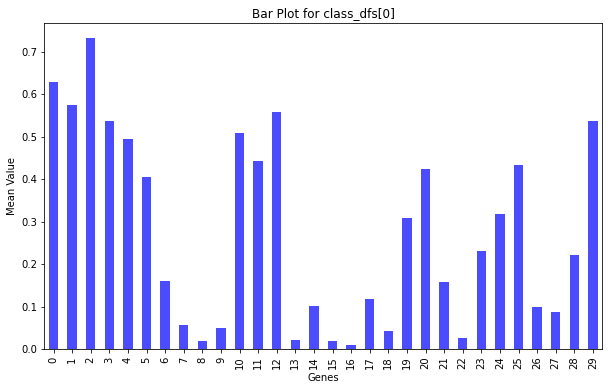

In [493]:
y

,Class
sample_0,4
sample_1,3
sample_2,4
sample_3,4
sample_4,0
...,...
sample_796,0
sample_797,3
sample_798,1
sample_799,4


In [420]:
def plot_polar_top(selected_df, col, name):

    if name == "Random Forest":
        selected_df = selected_df.reset_index()
    subset_df = selected_df[selected_df['Feature'].isin(overlap_genes)]
    new_df = convert_geneID(genes, subset_df)
    new_df = new_df.sort_values(by='Gene_ID') # sort for consistency
    # standardize all importances on scale 0 to 1
    new_df[col] = scaler.fit_transform(new_df[[col]])
    
    # Plotting on polar axis as dots with larger point size corresponding to importance
    theta = np.linspace(0, 2*np.pi, len(new_df), endpoint=False)
    values = new_df[col]

    # Adjust the point size by multiplying with a larger factor
    point_size = values * 100

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Plotting the dots with larger point size corresponding to importance
    scatter = ax.scatter(theta, values, s=point_size, alpha=0.7, cmap='GnBu', c=values)

    # Adding labels
    ax.set_xticks(theta)
    ax.set_xticklabels(new_df['Gene_ID'])
    ax.set_yticklabels([])  # Remove radial labels for better clarity

    # Add a colorbar to show the correspondence between size and importance
    # cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1)
    # cbar.set_label('Importance')

    # Add a title
    plt.title(f'{name}', pad=20)

    plt.show()

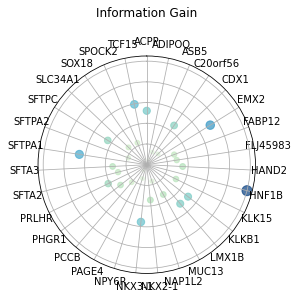

In [406]:
plot_polar_top(feature_scores_df_infogain, 'Information Gain', 'Information Gain')

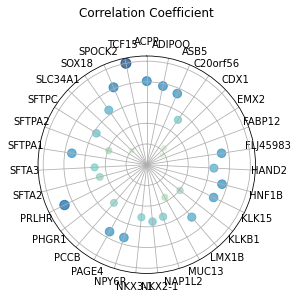

In [407]:
plot_polar_top(feature_scores_df, 'Correlation_Coefficient', 'Correlation Coefficient')

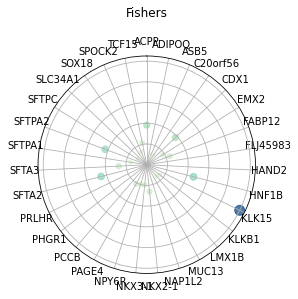

In [410]:
plot_polar_top(feature_scores_df_fish, 'Fisher_Score', 'Fishers')

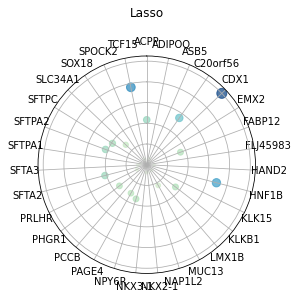

In [412]:
plot_polar_top(selected_features, 'Importance', 'Lasso')

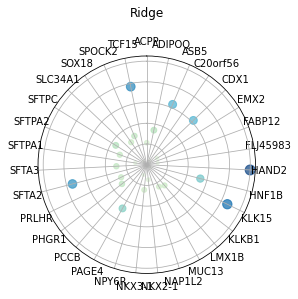

In [415]:
plot_polar_top(selected_features_ridge, 'Coefficient', 'Ridge')

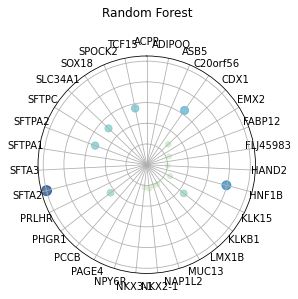

In [423]:
plot_polar_top(feature_importances_df, 'Importance', 'Random Forest')